In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [8]:
#assigning path for dataset
data_dir = 'archive'
train_path = 'archive/Train/'
test_path = 'archive/Test/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3


In [9]:
#finding total classes
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [10]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

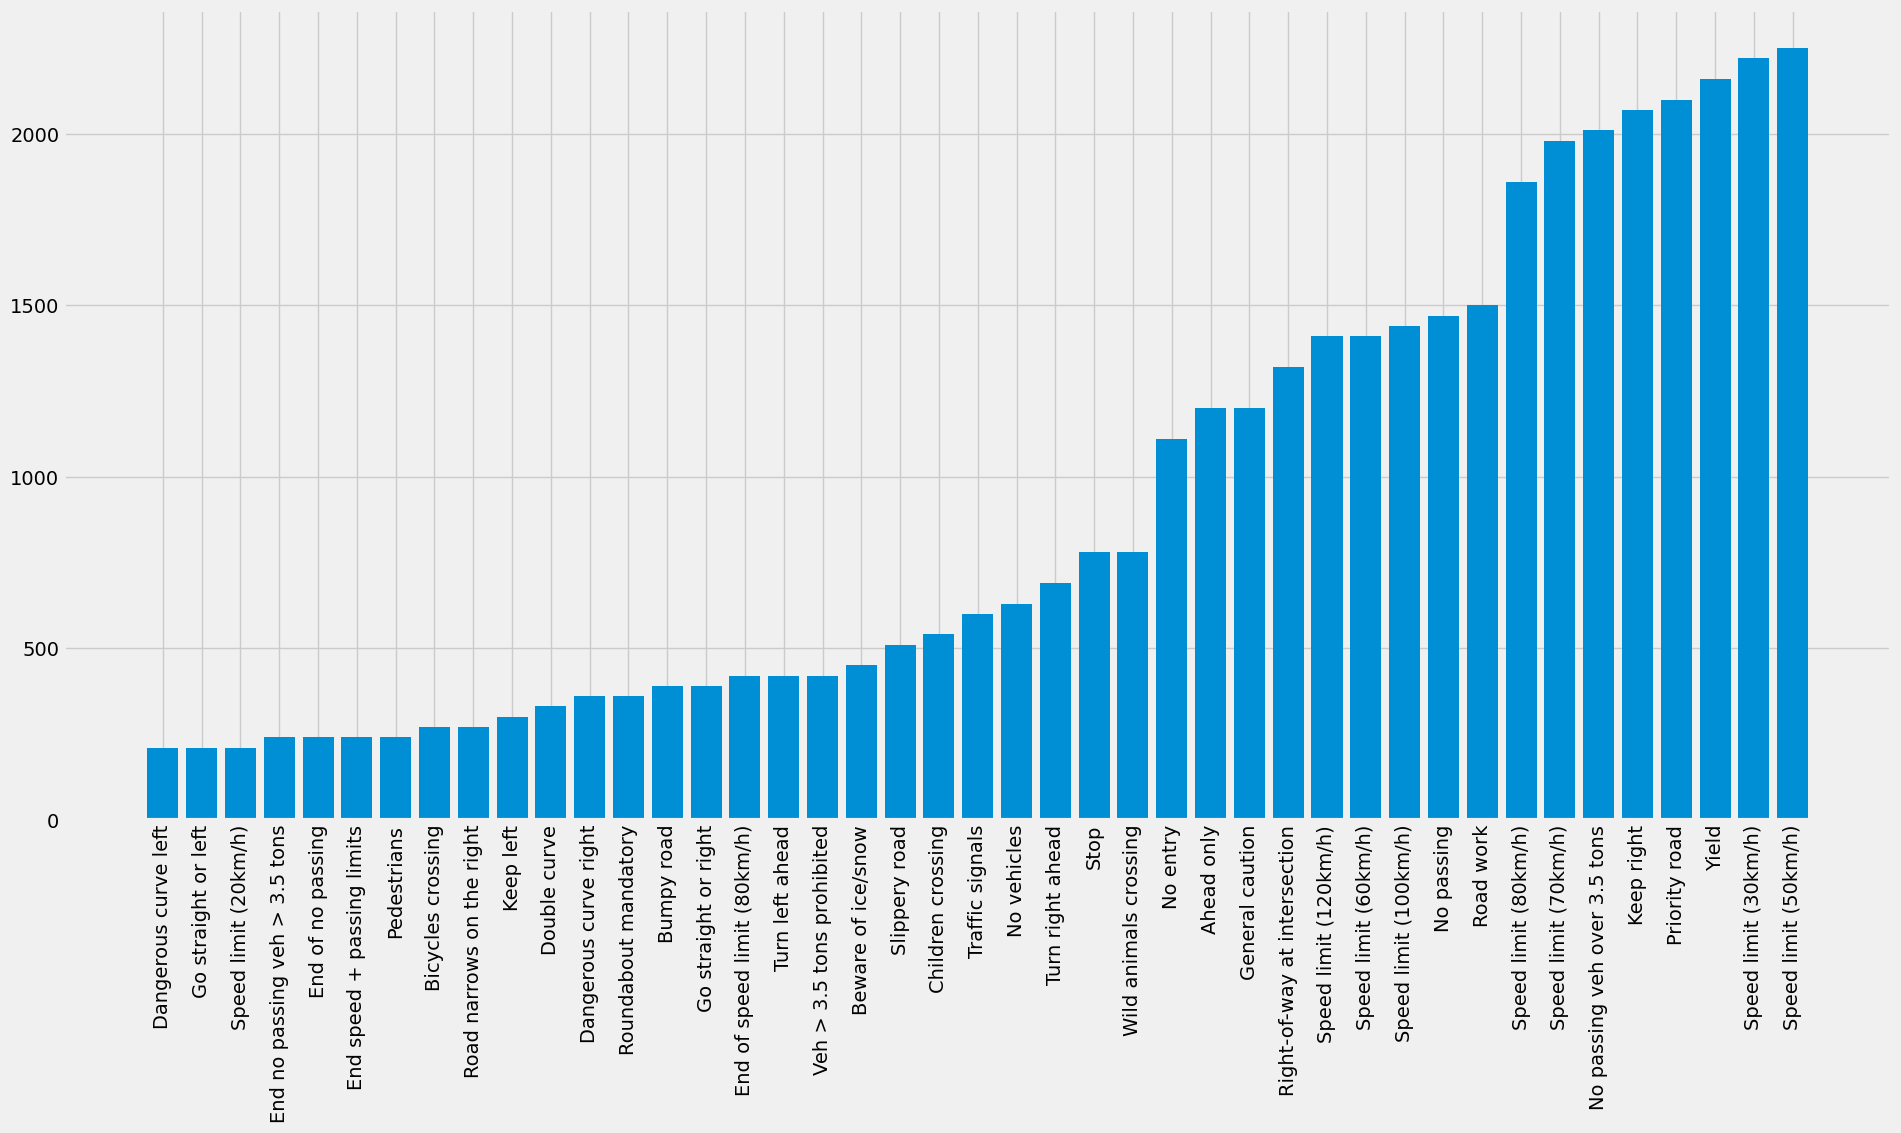

In [11]:
#visualizing the dataset
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

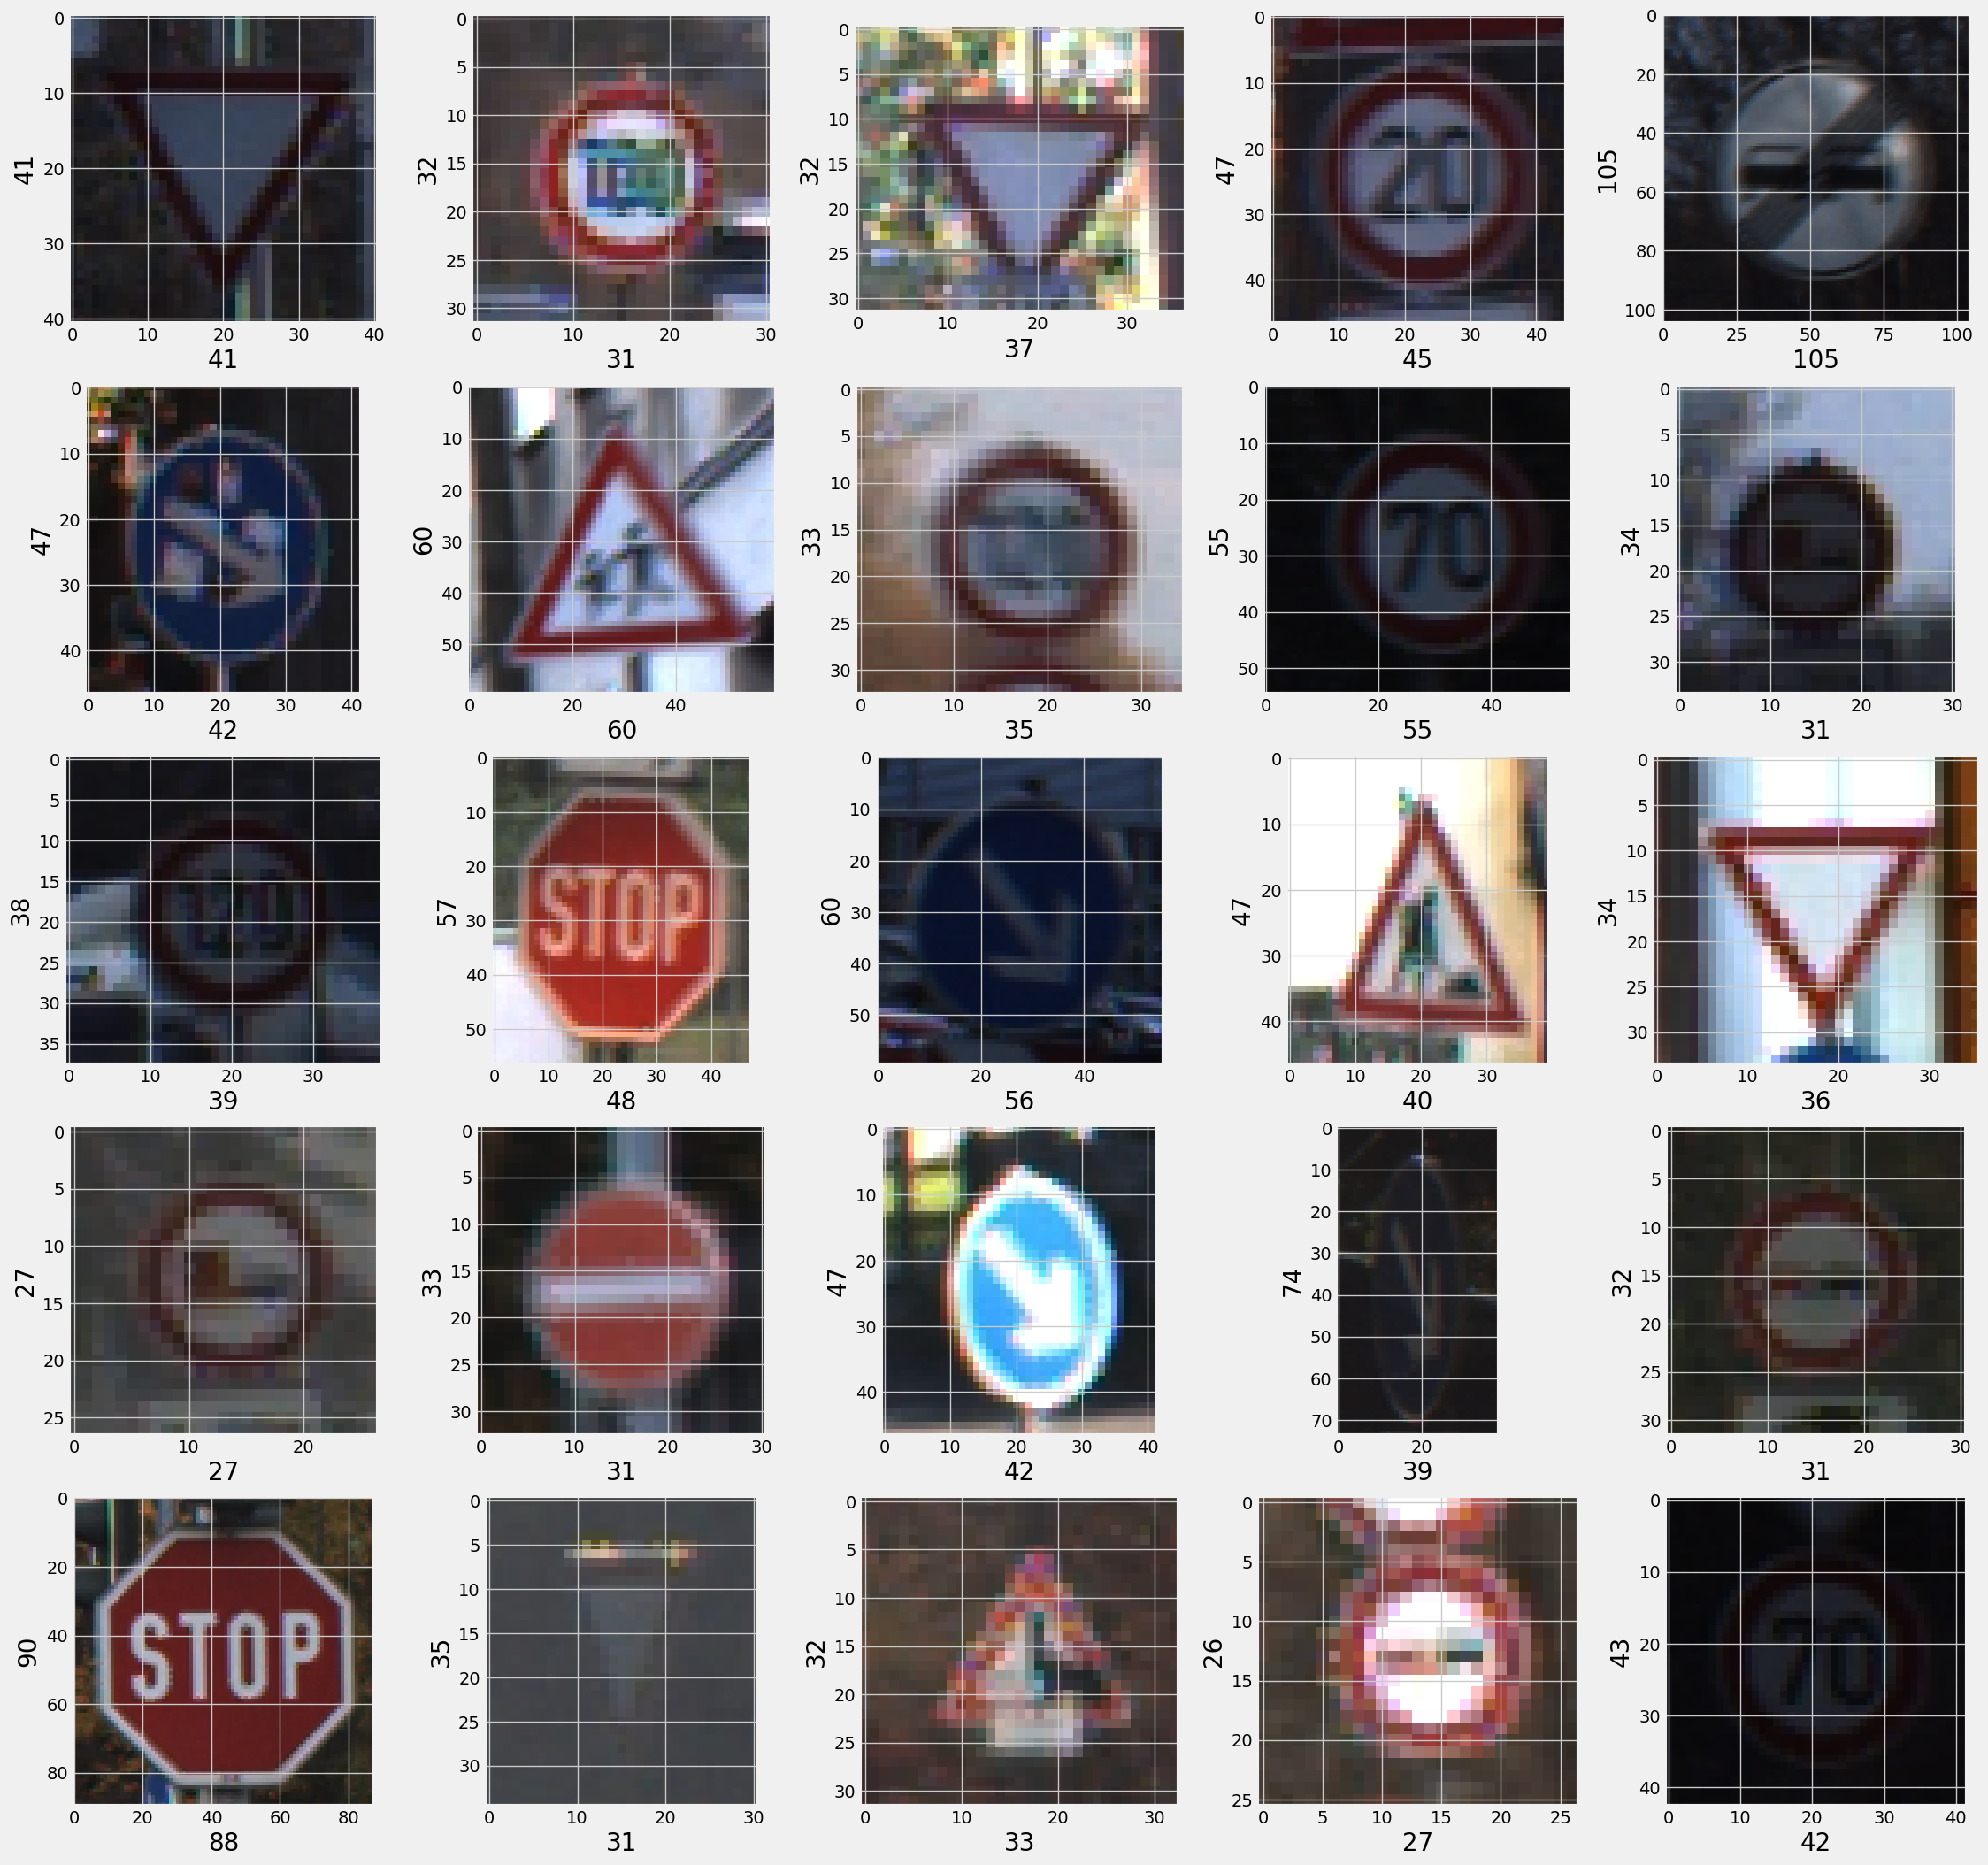

In [14]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    # plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [15]:
#Collecting Training data
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [16]:
#Shuffle the training data
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [17]:
#split train and test data
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# X_train = X_train/255 
# X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [18]:
#one hot encoding of target
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [19]:
#Making model
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [20]:
#epoch
lr = 0.001
epochs = 25

opt = Adam(learning_rate=lr, weight_decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [21]:
#Augumenting the data and training
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/25
858/858 [==============================] - 139s 158ms/step - loss: 1.0908 - accuracy: 0.7049 - val_loss: 0.1278 - val_accuracy: 0.9620
Epoch 2/25
858/858 [==============================] - 115s 134ms/step - loss: 0.1919 - accuracy: 0.9419 - val_loss: 0.0358 - val_accuracy: 0.9892
Epoch 3/25
858/858 [==============================] - 111s 130ms/step - loss: 0.1171 - accuracy: 0.9645 - val_loss: 0.0252 - val_accuracy: 0.9928
Epoch 4/25
858/858 [==============================] - 114s 133ms/step - loss: 0.0960 - accuracy: 0.9705 - val_loss: 0.0594 - val_accuracy: 0.9813
Epoch 5/25
858/858 [==============================] - 108s 126ms/step - loss: 0.0817 - accuracy: 0.9746 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 6/25
858/858 [==============================] - 121s 141ms/step - loss: 0.0803 - accuracy: 0.9752 - val_loss: 0.0116 - val_accuracy: 0.9960
Epoch 7/25
858/858 [==============================] - 119s 138ms/step - loss: 0.0612 - accuracy: 0.9812 - val_loss: 0.0591 -

<function matplotlib.pyplot.show(close=None, block=None)>

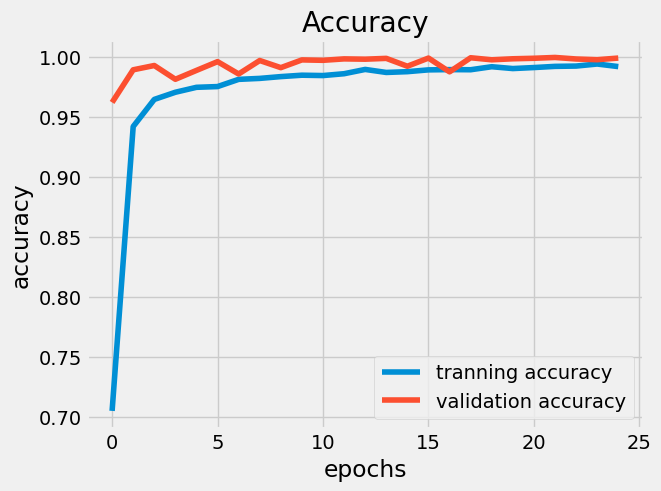

In [27]:
#accuracy
plt.figure(0)
plt.plot(history.history['accuracy'],label='tranning accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

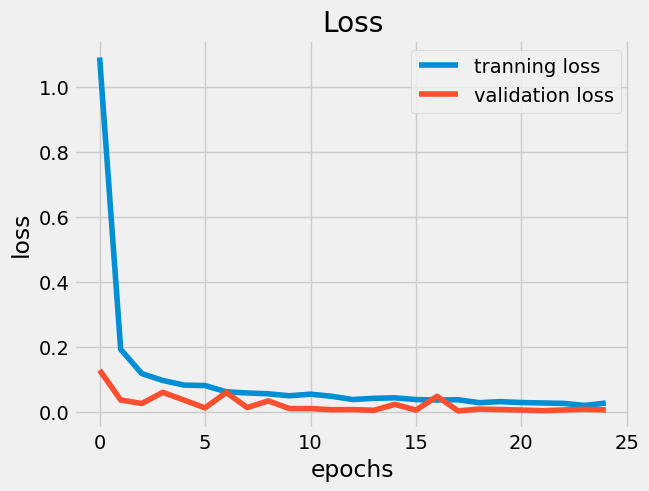

In [28]:
#Loss

plt.plot(history.history['loss'],label='tranning loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show

In [29]:
#loading test data and predictions
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
# X_test = X_test/255


predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)



#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 14s 32ms/step
Test Data accuracy:  98.35312747426762


In [30]:
#confusion metrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)
cf

array([[ 60,   0,   0, ...,   0,   0,   0],
       [  0, 720,   0, ...,   0,   0,   0],
       [  2,   4, 742, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  90,   0,   0],
       [  0,   0,   0, ...,   0,  60,   0],
       [  0,   0,   0, ...,   0,   0,  90]], dtype=int64)

<Axes: >

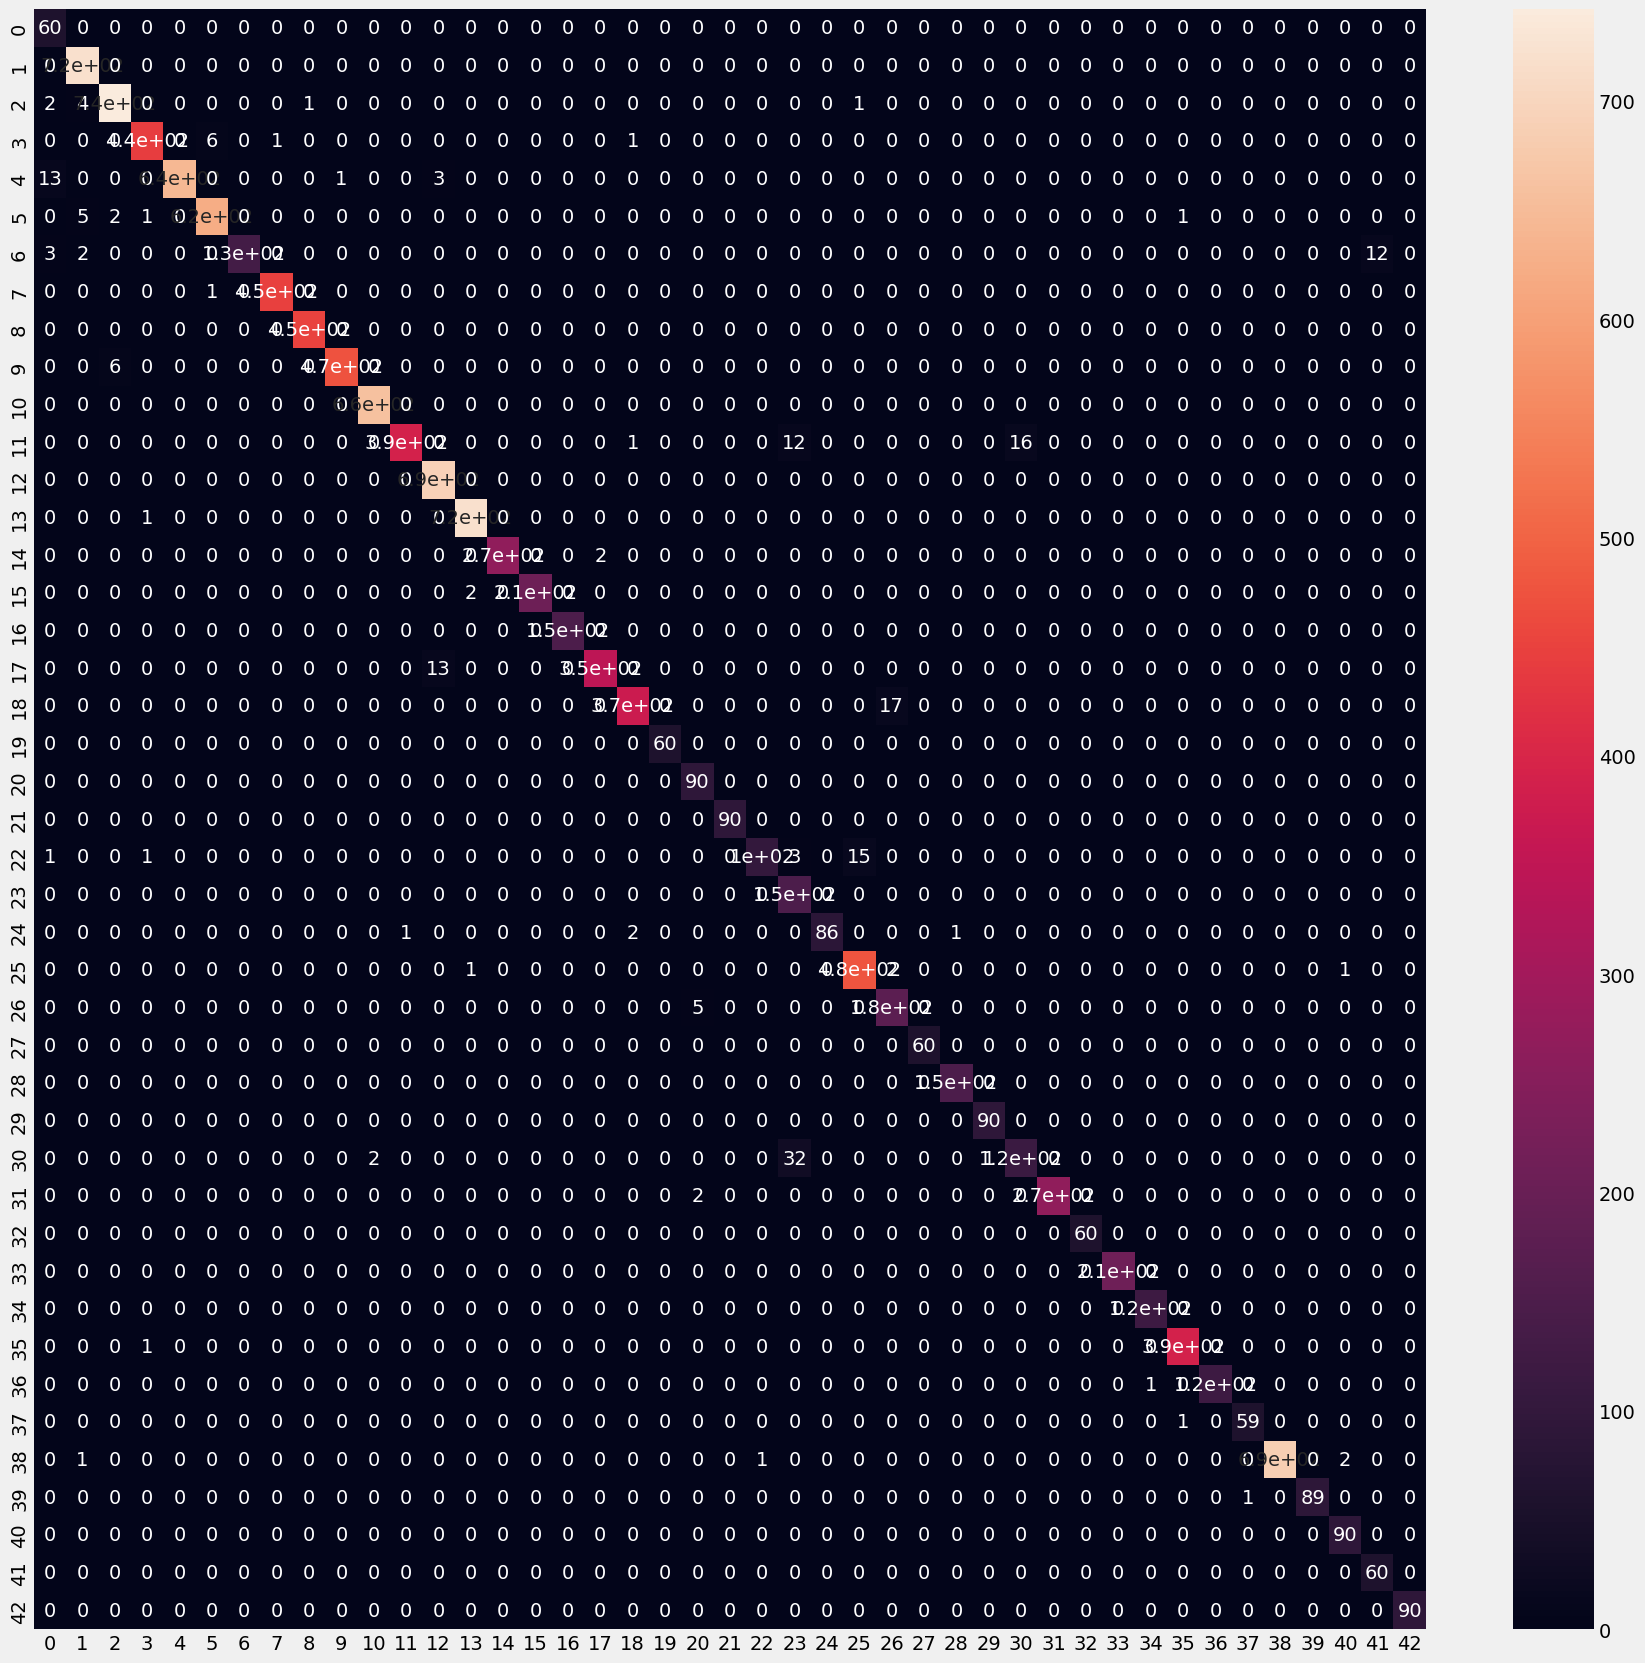

In [32]:
#visualizing confusion metrix
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [33]:
#classification report
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.99      0.98      0.99       450
           4       1.00      0.97      0.99       660
           5       0.99      0.99      0.99       630
           6       1.00      0.89      0.94       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      0.99      0.99       480
          10       1.00      1.00      1.00       660
          11       1.00      0.93      0.96       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      0.99      1.00       270
          15       1.00      0.99      1.00       210
          16       1.00      1.00      1.00       150
          17       0.99    

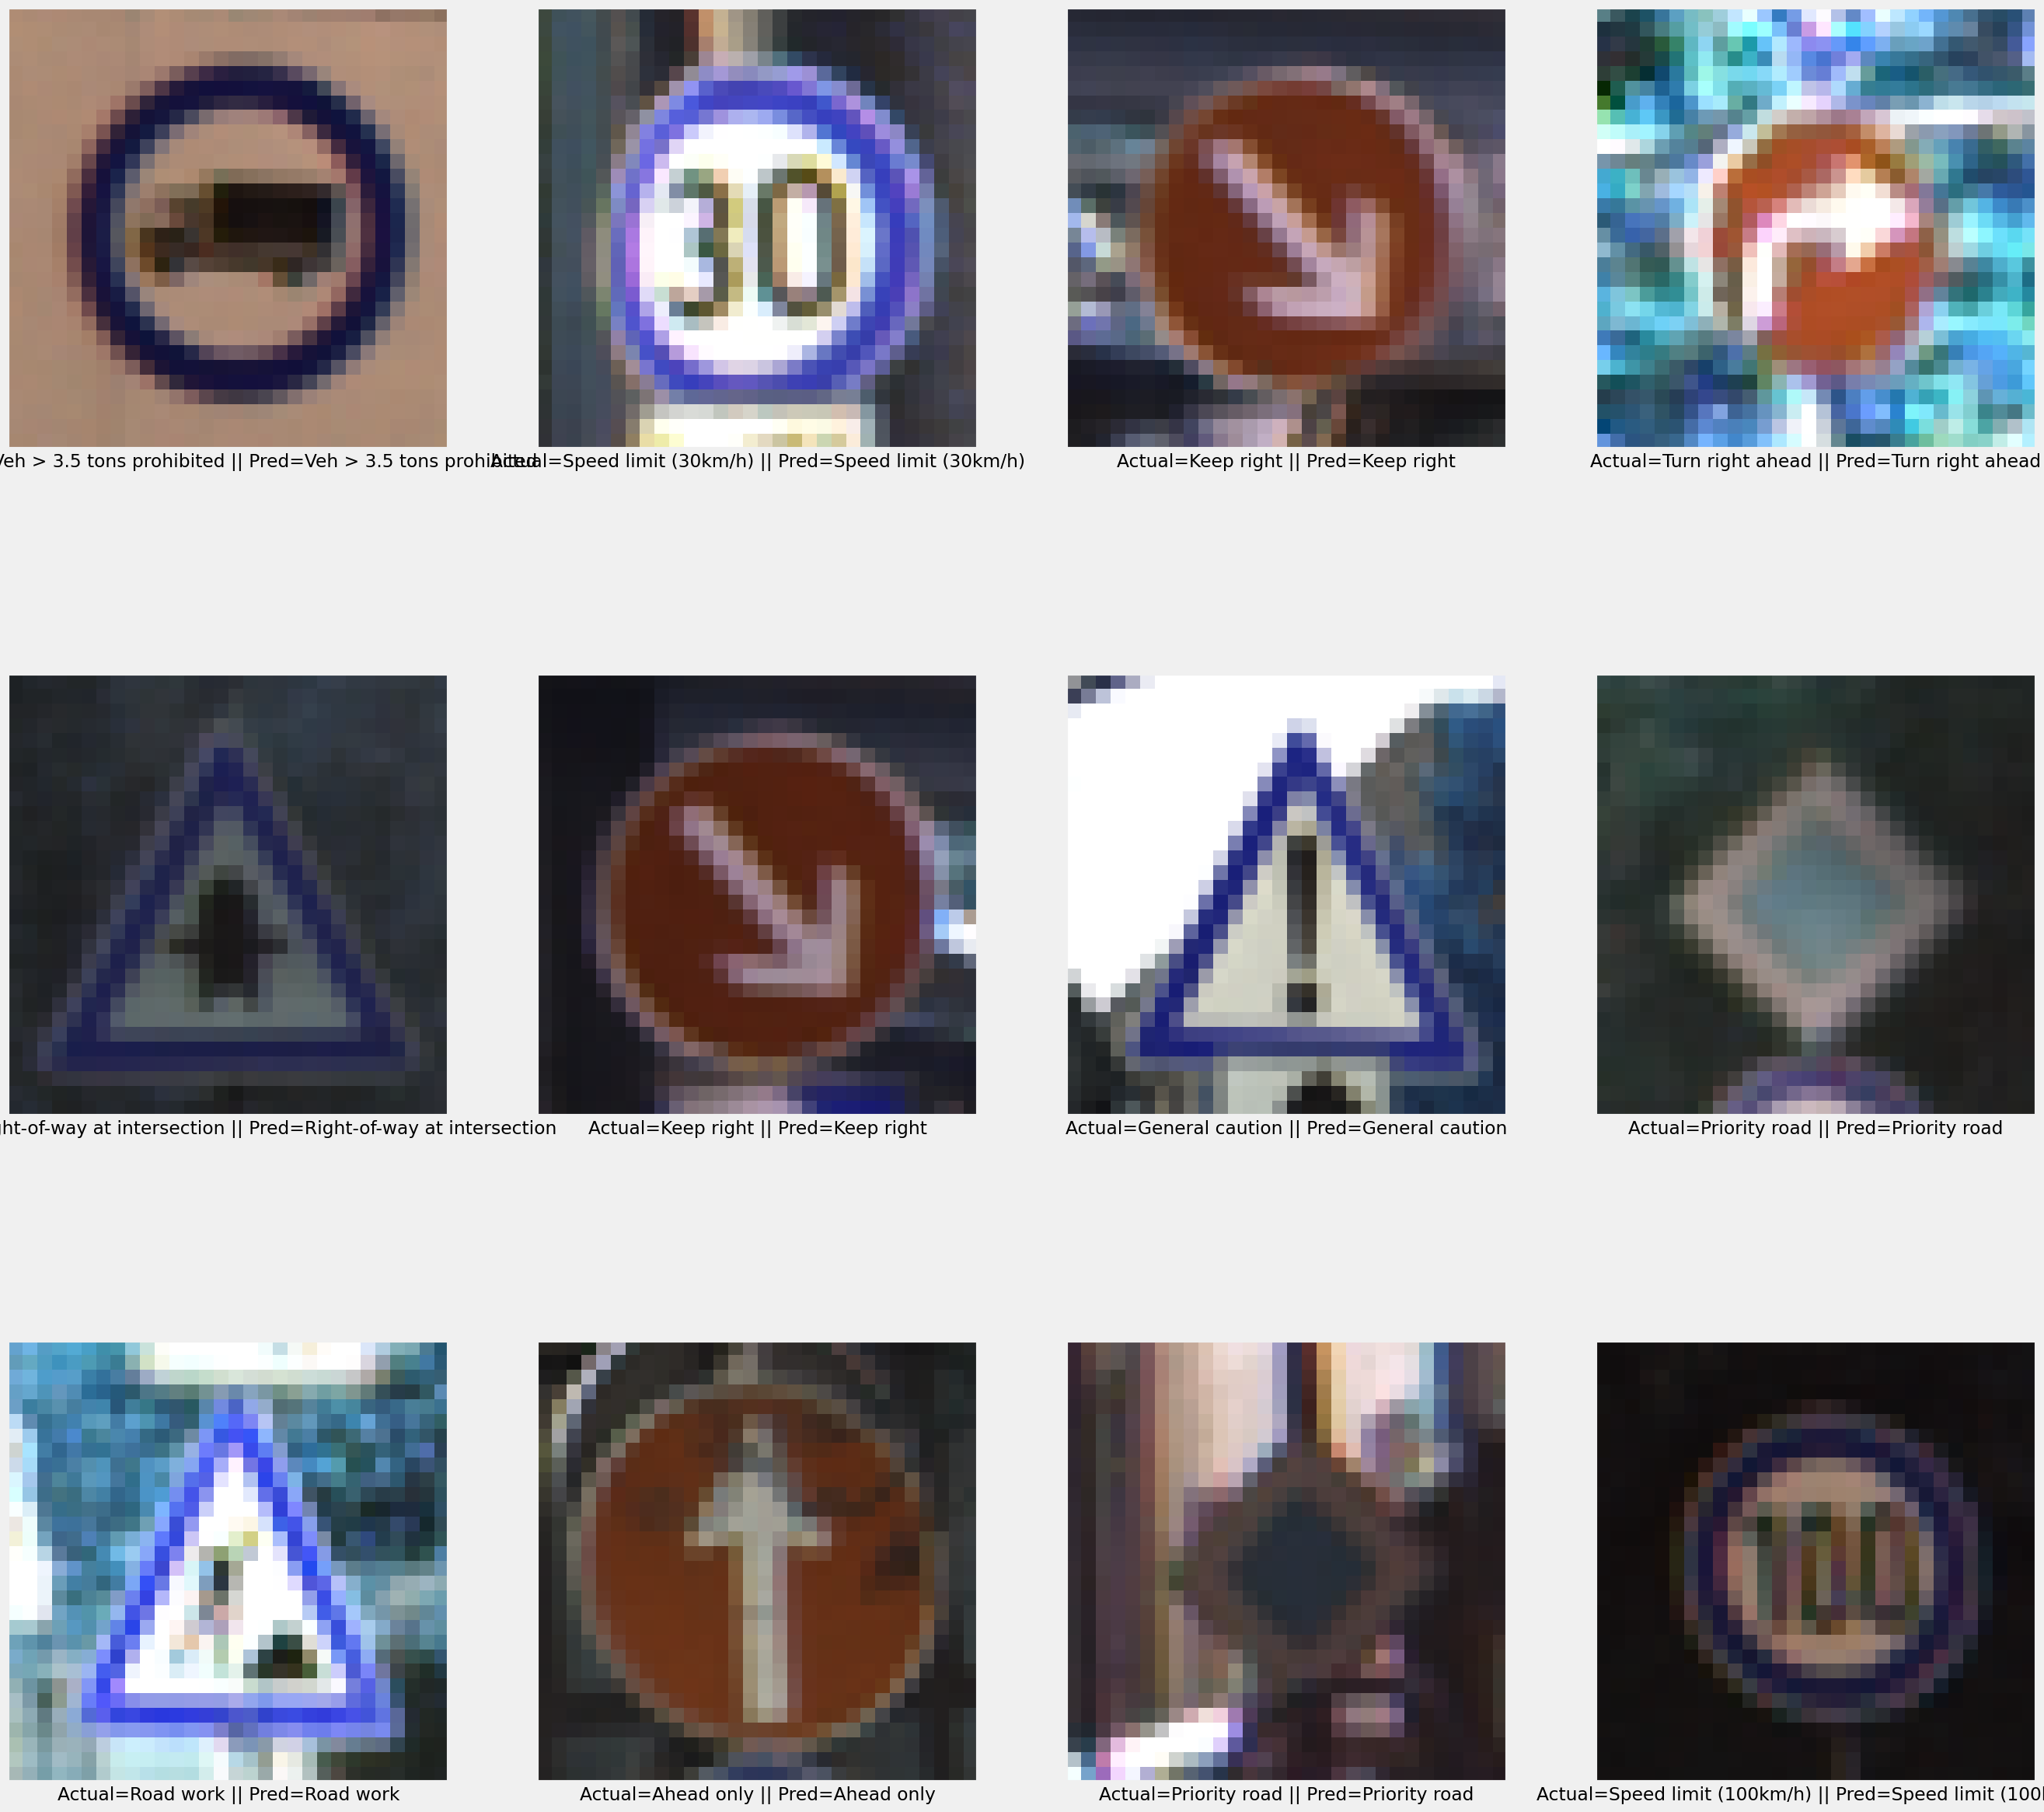

In [34]:
#prediction on test data
plt.figure(figsize = (30, 30))

start_index = 0
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'black'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(classes[actual], classes[prediction]), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [35]:
#prediction 
from PIL import Image

def predict_Image(img):
    data=[]
    image=Image.open(img).resize((30,30))
    data.append(np.array(image))
    X_test = np.array(data)
    
    predict_x=model.predict(X_test) 
    Y_pred=np.argmax(predict_x,axis=1)
    return image,Y_pred

In [1]:
plot,prediction = predict_Image('downloaded/5.jpg')
print("\nPredicted: " ,classes[prediction.item()]) #item() converts numpy int64 to native int
plt.imshow(plot)
plt.show()

NameError: name 'predict_Image' is not defined